This notebook exists to show the method used to find a 1D CNN that worked for this problem as well as providing an easy place to produce figures for the report. I started off using only one channel for simplicity however the resulting model was not learning enough to get over the problems caused by a skewed database, even when I weighted the classes accordingly. I belived I needed more data or that the model I was using was too big, (too many paramters). So I then looked into adding augmented data into the training set, through mirroring, scaling and shifting as well as reducing the size of the model through its hyperparameters. However this was still not enough. I then thought I might aswell chuck all the data I have at it so combined all 6 channels into one long array and used that. This lead to a model with much better performance!!!!

Most of the hyperparameters used here have been tuned mainly through trial and error.

In [1]:
from database.data import Data
from binary_NN import get_data_CNN, convert_data_to_CNN_format, make_model, train_model, get_split_data

#used to encoded strings to binary 
from sklearn.preprocessing import LabelEncoder

#used for cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#used for class weighting
from sklearn.utils import class_weight

import numpy as np

In [2]:
#defining train split ratio
train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3

#creating DATA object
ptb_binary_NN = Data(database = 'ptbdb', denoise_method=None, estimation_method = 'NN', train_splits=train_splits, binary = True, parameterisation = False)

#running preprocessing
ptb_binary_NN.run()

Filtering Database


100%|██████████| 221/221 [00:01<00:00, 124.89it/s]


splitting data into test and train


In [3]:
#just using 1 channel for now (0)
X_train = ptb_binary_NN.split_data[0]['X_train']
y_train = ptb_binary_NN.split_data[0]['y_train']

X_test = ptb_binary_NN.split_data[0]['X_test']
y_test = ptb_binary_NN.split_data[0]['y_test']

In [4]:
#as data set is small we can augment new data types, i.e. shift/mirror

def time_shift(data, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

def scale_data(data, scale_factor=0.1):
    scale = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    augmented_data = data * scale
    return augmented_data

def augment_data(data):
    augmented_data = []
    for signal in data:
        augmented_data.append(signal)
        augmented_data.append(time_shift(signal))
        augmented_data.append(scale_data(signal))
    return np.array(augmented_data)

In [5]:
X_train_aug = augment_data(X_train)
X_test_aug = augment_data(X_test)

#need to increase the size of the corresponding class data 
y_train_aug = np.tile(y_train, 3)
y_test_aug = np.tile(y_test, 3)

In [6]:
# NN needs encoded labels (1s and 0s) to perform comparissons and calculate probabilities 
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train_aug)
# y_test_encoded = label_encoder.transform(y_test_aug)

y_train_encoded = [0 if label == 'Unhealthy' else 1 for label in y_train_aug]
y_test_encoded = [0 if label == 'Unhealthy' else 1 for label in y_test_aug]

In [7]:
#CNN needs to know number of features per sample, i.e. 1D
X_train_cnn = np.expand_dims(X_train_aug, axis=-1) 
y_train_cnn = np.expand_dims(y_train_encoded, axis=-1) 
X_test_cnn = np.expand_dims(X_test_aug, axis=-1) 
y_test_cnn = np.expand_dims(y_test_encoded, axis=-1) 

In [8]:
#shows shape of arrays and also can see the skewed classes
print(X_train_cnn.shape)
print(X_test_cnn.shape)
print(y_test_cnn.shape)


print(sum(y_test_cnn))

(411, 60000, 1)
(177, 60000, 1)
(177, 1)
[39]


In [9]:
#finding class weight due to inbalanced class system
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.6462264150943396, 1: 2.2096774193548385}


In [10]:
# Define hyperparameters - find out what should be - currently done through trial and error
DEPTH = 1  #number of convolutional layers
FILTERS = 16  #number of filters in each layer
k = 3  # kernel size

# initialise model
cnn = Sequential()

for _ in range(DEPTH):
    cnn.add(Conv1D(filters=FILTERS, kernel_size=k, padding='same', input_shape = (60000, 1)))#each signal is always 60000 samples long
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling1D(pool_size=3))  # takes max out of every three, also regularisation
    cnn.add(Dropout(0.5)) #used for regularisation, removes certain percentage of samples each time

cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))  # use 'softmax' for multi-class classification, 'sigmoid' for binary classification

# build/compile empty model
cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) #binary cross entropy for binary classification

#allows you to see the model is built properly
print(cnn.summary())

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60000, 8)       │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60000, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       160,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 160,049 (625.19 KB)

 Non-trainable params: 16 (64.00 B)

None


In [11]:
#fitting the model whilst keeping track of the history for later use

history = cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20, #number of repeats 
    batch_size=16,
    validation_data=(X_test_cnn, y_test_cnn),
    class_weight=class_weights_dict #weights training data
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.5077 - loss: 11.2277 - val_accuracy: 0.7797 - val_loss: 0.8781
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - accuracy: 0.6810 - loss: 4.2804 - val_accuracy: 0.5085 - val_loss: 0.7733
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 188ms/step - accuracy: 0.6557 - loss: 1.7866 - val_accuracy: 0.7514 - val_loss: 0.7757
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.6633 - loss: 2.9685 - val_accuracy: 0.5141 - val_loss: 0.7870
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.7147 - loss: 1.3873 - val_accuracy: 0.5311 - val_loss: 0.8219
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.8329 - loss: 0.5031 - val_accuracy: 0.6215 - val_loss: 0.7248
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.8350 - loss: 0.5715 - val_accuracy: 0.6271 - val_loss: 0.6987
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.8122 - loss: 1.2003 - val_accuracy: 0

In [12]:
#we can see that this is limited as there is not enough data to overcome the class inblance, accuracy = class inbalnce
loss, accuracy = cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6800 - loss: 0.6382
Validation loss: 0.6420843601226807
Validation accuracy: 0.6723163723945618


The above has resulted in a model that has only guessed positive or negative, after considerable fine tuning of parameters to no avail, I believe this to be due to not enough data so below is a repeat with all the data. To allow easy manipulation and repeats I shall use functions.

In [2]:
#maybe limited by amount of data so instead lets try using all the data available, i.e. all 6 channels

#obtaining original data first, takes time to filter so done outside loop
data, labels = get_data_CNN(splits=None, denoise_method = None)


train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3

repeats = 5

hist_list = []
model_list = []
data_list = []
labels_list = []
for i in range(repeats):
    #splitting data
    split_data = get_split_data(train_splits, data, labels)

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20 #20
    BATCH_SIZE = 16

    #training model keeping track of history
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:01<00:00, 141.01it/s]


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - accuracy: 0.5447 - loss: 30.1993 - val_accuracy: 0.8279 - val_loss: 0.6471
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.7747 - loss: 2.1283 - val_accuracy: 0.5252 - val_loss: 1.4352
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.9230 - loss: 0.4789 - val_accuracy: 0.6291 - val_loss: 1.2265
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.9184 - loss: 0.6081 - val_accuracy: 0.8279 - val_loss: 0.4744
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9981 - loss: 0.0306 - val_accuracy: 0.8813 - val_loss: 0.3896
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.9964 - loss: 0.0517 - val_accuracy: 0.8546 - val_loss: 0.4175
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9976 - loss: 0.0286 - val_accuracy: 0.9021 - val_loss: 0.3500
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 1.0000 - loss: 0.0105 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.6429 - loss: 18.0351 - val_accuracy: 0.8487 - val_loss: 0.6208
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.7850 - loss: 3.8570 - val_accuracy: 0.8042 - val_loss: 0.5774
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.8561 - loss: 1.5789 - val_accuracy: 0.8249 - val_loss: 0.4460
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.8780 - loss: 0.9499 - val_accuracy: 0.6291 - val_loss: 1.7736
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9303 - loss: 0.4916 - val_accuracy: 0.7062 - val_loss: 0.9816
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9200 - loss: 0.3634 - val_accuracy: 0.9110 - val_loss: 0.3747
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 362ms/step - accuracy: 0.9633 - loss: 0.2358 - val_accuracy: 0.9496 - val_loss: 0.2845
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.9875 - loss: 0.0382 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.5308 - loss: 19.9769 - val_accuracy: 0.6024 - val_loss: 1.1647
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.7988 - loss: 2.3887 - val_accuracy: 0.5875 - val_loss: 2.9269
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step - accuracy: 0.8013 - loss: 2.3911 - val_accuracy: 0.8813 - val_loss: 0.5952
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9125 - loss: 1.4403 - val_accuracy: 0.6944 - val_loss: 1.2219
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - accuracy: 0.8667 - loss: 1.4105 - val_accuracy: 0.7567 - val_loss: 0.6163
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 355ms/step - accuracy: 0.9184 - loss: 0.6567 - val_accuracy: 0.8754 - val_loss: 0.3931
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 354ms/step - accuracy: 0.9744 - loss: 0.1778 - val_accuracy: 0.9347 - val_loss: 0.3256
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - accuracy: 0.9819 - loss: 0.0821 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 357ms/step - accuracy: 0.5663 - loss: 18.0923 - val_accuracy: 0.6053 - val_loss: 4.1977
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - accuracy: 0.7356 - loss: 7.2420 - val_accuracy: 0.5460 - val_loss: 3.4184
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 342ms/step - accuracy: 0.8342 - loss: 2.9115 - val_accuracy: 0.7834 - val_loss: 1.0059
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.8518 - loss: 1.1223 - val_accuracy: 0.8991 - val_loss: 0.4065
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.9544 - loss: 0.5891 - val_accuracy: 0.9050 - val_loss: 0.3193
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.9618 - loss: 0.3922 - val_accuracy: 0.8724 - val_loss: 0.6913
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 343ms/step - accuracy: 0.9519 - loss: 0.7944 - val_accuracy: 0.7240 - val_loss: 1.4866
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.9764 - loss: 0.1589 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 359ms/step - accuracy: 0.5574 - loss: 18.6597 - val_accuracy: 0.6528 - val_loss: 1.7576
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.7654 - loss: 4.0838 - val_accuracy: 0.7478 - val_loss: 1.5752
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 349ms/step - accuracy: 0.8561 - loss: 1.6827 - val_accuracy: 0.9496 - val_loss: 0.2115
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.9359 - loss: 0.6949 - val_accuracy: 0.8635 - val_loss: 0.5622
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.8954 - loss: 0.7765 - val_accuracy: 0.8190 - val_loss: 0.8698
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9063 - loss: 0.7862 - val_accuracy: 0.7656 - val_loss: 0.9048
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 348ms/step - accuracy: 0.9801 - loss: 0.0600 - val_accuracy: 0.7300 - val_loss: 1.5526
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.9873 - loss: 0.0454 - val_acc

In [3]:
loss, accuracy = model_list[0].evaluate(data_list[0]['X_test'], data_list[0]['y_test'])#continue this
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9615 - loss: 0.2018
Validation loss: 0.17736192047595978
Validation accuracy: 0.9614243507385254


## Metrics for table

In [4]:
from sklearn.metrics import classification_report
from models.scoring_metrics import get_all_metrics
from models.SVM.binary_classification import manual_y_predict

performance_metrics = []
for i in range(repeats):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']


    y_pred = model_list[i].predict(X_test)

    threshold = 1-np.sum(y_test)/len(y_test)

    #threshold = 0.3

    y_pred_classes = manual_y_predict(y_pred, threshold)
    
    y_pred_encoded = (y_pred > threshold).astype(int)


    performance_metrics.append(get_all_metrics(labels_list[i], y_pred_classes))
    

    print(classification_report(y_test, y_pred_encoded))

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       264
           1       0.98      0.63      0.77        73

    accuracy                           0.92       337
   macro avg       0.94      0.81      0.86       337
weighted avg       0.92      0.92      0.91       337

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       264
           1       1.00      0.68      0.81        73

    accuracy                           0.93       337
   macro avg       0.96      0.84      0.89       337
weighted avg       0.94      0.93      0.93       337

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       264
           1       1.00      0.63      0.77        73

    accuracy                           0.92       337
   ma

In [5]:
# Initialize an empty dictionary to store averaged scores
averaged_scores = {}

# Iterate through each channel in the dictionaries
for metric in performance_metrics[0].keys():
    # Calculate the average of the current metric
    values = [score[metric] for score in performance_metrics]
    mean_value = np.mean(values)
    std_value = np.std(values)
    averaged_scores[metric] = (mean_value, std_value)

# Print the averaged scores with 2 decimal places
for metric, (mean_value, std_value) in averaged_scores.items():
    print(f'  {metric}: {mean_value:.2f} ± {std_value:.2f}')
print()

  bal acc: 0.83 ± 0.03
  accuracy: 0.92 ± 0.01
  f1: 0.79 ± 0.04
  obj score: 0.80 ± 0.04
  recall: 0.66 ± 0.06
  precision: 0.99 ± 0.01



In [6]:
#need to make all epoch arrays same length so averages can be calculated
accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []

for i in range(repeats):

    accuracy_list.append(hist_list[i].history['accuracy'])
    val_accuracy_list.append(hist_list[i].history['val_accuracy'])
    loss_list.append(hist_list[i].history['loss'])
    val_loss_list.append(hist_list[i].history['val_loss'])

In [7]:
def extend_arrays_to_max_length(arrays):
    # Determine the maximum length of the arrays
    max_length = max(len(arr) for arr in arrays)
    
    # Convert all arrays to numpy arrays for easier manipulation
    arrays = [np.array(arr) for arr in arrays]
    
    # Create a new list to hold the extended arrays
    extended_arrays = []
    
    for arr in arrays:
        # Calculate the length of the current array
        current_length = len(arr)
        
        if current_length < max_length:
            # If the current array is shorter than the maximum length, extend it
            # Create a placeholder for the new elements
            new_elements = []
            
            for i in range(current_length, max_length):
                # Calculate the average for this position from other arrays
                # Filter out arrays that are shorter than the current index
                valid_values = [other_arr[i] for other_arr in arrays if len(other_arr) > i]
                # Compute the average
                avg_value = np.mean(valid_values)
                new_elements.append(avg_value)
            
            # Append the new elements to the original array
            extended_arr = np.concatenate([arr, new_elements])
        else:
            # If the current array is already the maximum length, keep it as is
            extended_arr = arr
        
        # Add the extended array to the list
        extended_arrays.append(extended_arr)
    
    return extended_arrays

In [8]:
history_dict = {}

history_dict['loss'] = extend_arrays_to_max_length(loss_list)
history_dict['val_loss'] = extend_arrays_to_max_length(val_loss_list)
history_dict['val_acc'] = extend_arrays_to_max_length(val_accuracy_list)
history_dict['acc'] = extend_arrays_to_max_length(accuracy_list)


## Model Performance

[]

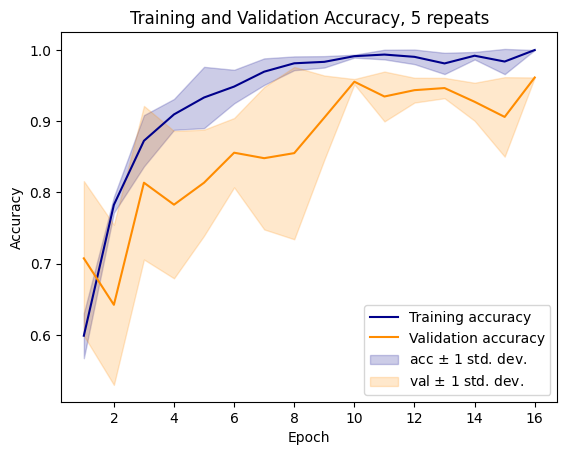

In [9]:
import matplotlib.pyplot as plt

full_acc_list = []
full_val_list = []
for i in range(repeats):
    full_acc_list.append(history_dict['acc'][i])
    full_val_list.append(history_dict['val_acc'][i])


average_acc = np.mean(full_acc_list, axis = 0)
average_val = np.mean(full_val_list, axis=0)
std_acc = np.std(full_acc_list, axis=0)
std_val = np.std(full_val_list, axis=0)


epochs = range(1, len(average_acc) + 1)

plt.plot(epochs, average_acc, color='darkblue', label='Training accuracy')
plt.plot(epochs, average_val, color='darkorange', label='Validation accuracy')
plt.fill_between(epochs, average_acc - std_acc, average_acc + std_acc, color='darkblue', alpha=.2, label=r'acc $\pm$ 1 std. dev.')
plt.fill_between(epochs, average_val - std_val, average_val + std_val, color='darkorange', alpha=.2, label=r'val $\pm$ 1 std. dev.')
plt.title(f'Training and Validation Accuracy, {repeats} repeats')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('figures\\train_vs_val_acc.png', bbox_inches='tight')
plt.plot()

[]

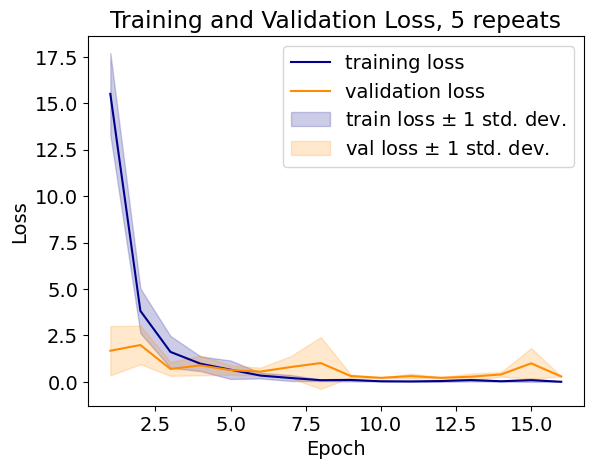

In [30]:
#same for loss

full_loss_list = []
full_val_loss_list = []
for i in range(repeats):
    full_loss_list.append(history_dict['loss'][i])
    full_val_loss_list.append(history_dict['val_loss'][i])

average_loss = np.mean(full_loss_list, axis = 0)
average_val_loss = np.mean(full_val_loss_list, axis=0)
std_loss = np.std(full_loss_list, axis=0)
std_val_loss = np.std(full_val_loss_list, axis=0)


plt.plot(epochs, average_loss, color='darkblue', label='training loss')
plt.plot(epochs, average_val_loss, color='darkorange', label='validation loss')
plt.fill_between(epochs, average_loss - std_loss, average_loss + std_loss, color='darkblue', alpha=.2, label=r'train loss $\pm$ 1 std. dev.')
plt.fill_between(epochs, average_val_loss - std_val_loss, average_val_loss + std_val_loss, color='darkorange', alpha=.2, label=r'val loss $\pm$ 1 std. dev.')
plt.title(f'Training and Validation Loss, {repeats} repeats')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig('figures\\train_vs_val_loss.png', bbox_inches='tight')
plt.plot()

## ROC curve

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step


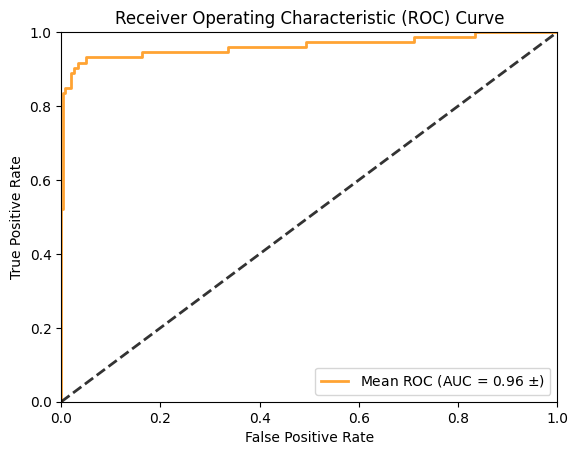

In [11]:
from sklearn.metrics import roc_curve, auc

y_test = data_list[0]['y_test']
X_test = data_list[0]['X_test']


y_pred = model_list[0].predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

# plotting average ROC curve for all iterations
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$)' % (roc_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
from sklearn.metrics import roc_curve, auc


mean_fpr = np.linspace(0, 1, 100)#roc_curve produces different length arrays so need to standardise

auc_list = []
interp_tpr_list = []
for i in range(repeats):
    y_test = data_list[i]['y_test']
    X_test = data_list[i]['X_test']

    y_pred = model_list[i].predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    auc_list.append(auc(fpr, tpr))

    #need to interpolate everything so they are the desired length
    interp_tpr_list.append(np.interp(mean_fpr, fpr, tpr))



mean_tpr = np.mean(interp_tpr_list, axis = 0)
mean_auc = np.mean(auc_list, axis=0)

std_tpr = np.std(interp_tpr_list, axis=0)
std_auc = np.std(auc_list, axis=0)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


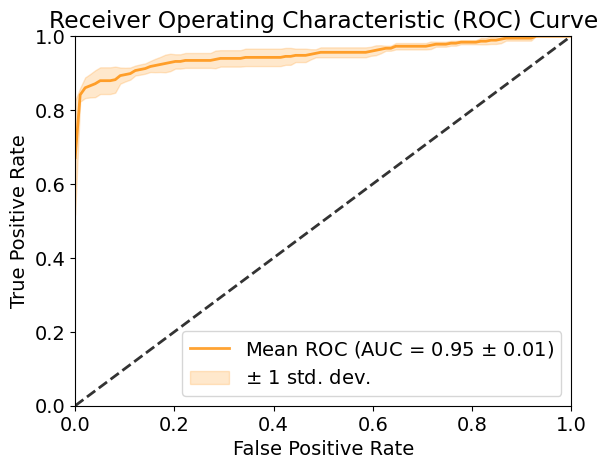

In [26]:
# plotting average ROC curve for all iterations
plt.figure()
plt.rcParams.update({'font.size': 14})
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='darkorange', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figures\\ROC_CNN.png', bbox_inches='tight')
plt.show()

## Confusion Matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


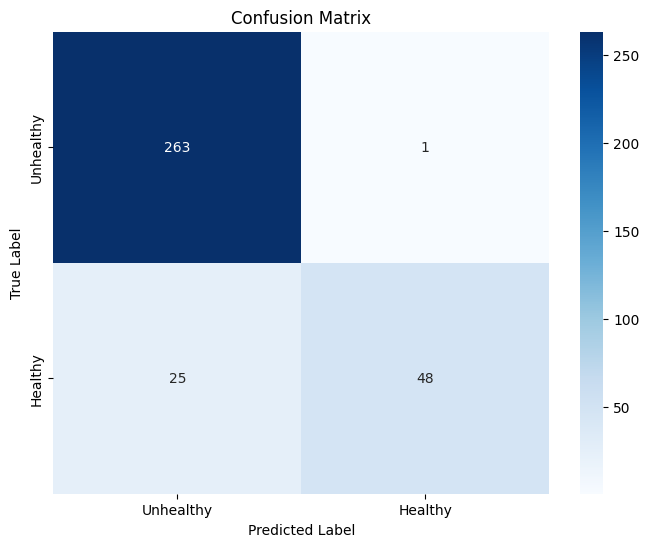

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# need to average a load of confusion matrices
cm_sum = np.zeros((2, 2), dtype=int)  # 2*2 for binary classification
cm_list = []
for i in range(repeats):
    y_test = data_list[i]['y_test']
    X_test = data_list[i]['X_test']

    y_pred = model_list[i].predict(X_test)

    threshold = 1-np.sum(y_test)/len(y_test)

    y_pred_encoded = (y_pred > threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred_encoded)
    cm_sum += cm

    cm_list.append(cm)


# average total cm 
cm_avg = cm_sum / repeats

# Calculate the variance and standard deviation
cm_variance = np.zeros((2, 2), dtype=float)
for cm in cm_list:
    cm_variance += (cm - cm_avg) ** 2

cm_variance /= repeats
cm_std_dev = np.sqrt(cm_variance)

# rounding to integers
cm_avg_rounded = np.round(cm_avg).astype(int)
cm_std_dev_rounded = np.round(cm_std_dev).astype(int)


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_avg_rounded, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('figures\\confusion_matrix_CNN.png', bbox_inches='tight')
plt.show()

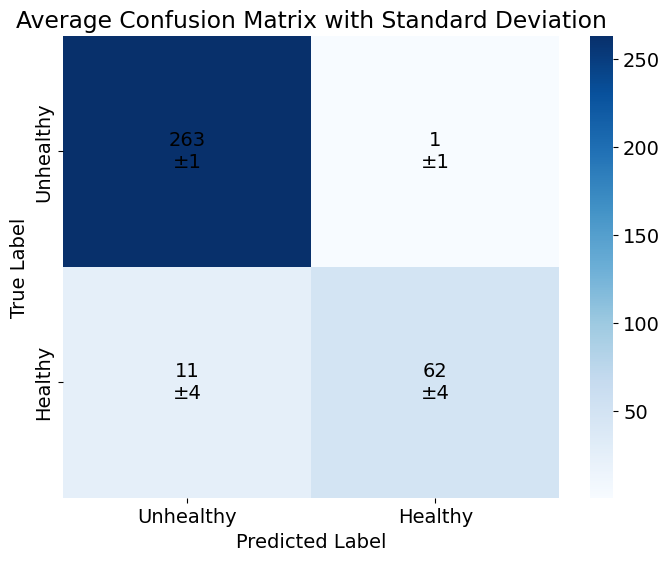

In [31]:
# # Create confusion matrix data
# cm_avg_rounded = np.array([[263, 1],
#                              [11, 62]])

# # Create standard deviation data
# cm_std_devs_rounded = np.array([[2, 2],
#                      [4, 4]])

# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_avg, annot=False, cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])

# Add annotations for both average values and standard deviation
for i in range(cm_avg.shape[0]):
    for j in range(cm_avg.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_avg_rounded[i, j]}\n±{cm_std_dev_rounded[i, j]}', 
                 ha='center', va='center', color='black')
        

plt.rcParams.update({'font.size': 14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix with Standard Deviation')
plt.savefig('figures/confusion_matrix_CNN.png', bbox_inches='tight')
plt.show()

## How results vary with different train test splits

In [73]:
#obtaining original data first, takes time to filter so done outside loop
data, labels = get_data_CNN(splits=None, denoise_method = None)

#listing different train test splits
train_splits_list = []

train_splits2 = {}
train_splits2['train'] = 0.8
train_splits2['test'] = 0.2
train_splits_list.append(train_splits2)

train_splits1 = {}
train_splits1['train'] = 0.7
train_splits1['test'] = 0.3
train_splits_list.append(train_splits1)

train_splits3 = {}
train_splits3['train'] = 0.6
train_splits3['test'] = 0.4
train_splits_list.append(train_splits3)

train_splits4 = {}
train_splits4['train'] = 0.5
train_splits4['test'] = 0.5
train_splits_list.append(train_splits4)

train_splits5 = {}
train_splits5['train'] = 0.4
train_splits5['test'] = 0.6
train_splits_list.append(train_splits5)

train_splits6 = {}
train_splits6['train'] = 0.3
train_splits6['test'] = 0.7
train_splits_list.append(train_splits6)


hist_list = []
model_list = []
data_list = []
labels_list = []
for i in range(0, len(train_splits_list)):
    #splitting data
    split_data = get_split_data(train_splits_list[i], data, labels)

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20
    BATCH_SIZE = 16

    #should put epochs and stuff outside here
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 80.34it/s] 


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.5659 - loss: 25.9120 - val_accuracy: 0.8899 - val_loss: 0.5425
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.8707 - loss: 1.5601 - val_accuracy: 0.5727 - val_loss: 3.8302
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8500 - loss: 2.5814 - val_accuracy: 0.5859 - val_loss: 2.5297
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8521 - loss: 1.6452 - val_accuracy: 0.9075 - val_loss: 0.4202
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.9288 - loss: 0.8235 - val_accuracy: 0.8326 - val_loss: 0.8548
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.9512 - loss: 0.3927 - val_accuracy: 0.8282 - val_loss: 0.5530
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.9371 - loss: 0.3632 - val_accuracy: 0.8943 - val_loss: 0.4872
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.9657 - loss: 0.1559 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.6220 - loss: 7.1861 - val_accuracy: 0.7270 - val_loss: 1.4056
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.7983 - loss: 5.6835 - val_accuracy: 0.6409 - val_loss: 1.0050
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.9135 - loss: 1.1602 - val_accuracy: 0.7240 - val_loss: 0.9444
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9177 - loss: 0.6385 - val_accuracy: 0.8724 - val_loss: 0.5834
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9040 - loss: 1.3697 - val_accuracy: 0.9050 - val_loss: 0.3810
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.9730 - loss: 0.1850 - val_accuracy: 0.8042 - val_loss: 0.5067
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9851 - loss: 0.1001 - val_accuracy: 0.8576 - val_loss: 0.4661
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.9724 - loss: 0.1257 - val_accu

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6563 - loss: 17.6622 - val_accuracy: 0.5200 - val_loss: 1.5399
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.7403 - loss: 4.1578 - val_accuracy: 0.6600 - val_loss: 1.0563
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - accuracy: 0.8652 - loss: 1.6973 - val_accuracy: 0.8378 - val_loss: 0.7574
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9181 - loss: 1.9331 - val_accuracy: 0.7978 - val_loss: 0.5189
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.9445 - loss: 0.4190 - val_accuracy: 0.8711 - val_loss: 0.3971
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - accuracy: 0.9870 - loss: 0.1547 - val_accuracy: 0.8444 - val_loss: 0.4141
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9709 - loss: 0.0999 - val_accuracy: 0.7867 - val_loss: 0.6064
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - accuracy: 0.9859 - loss: 0.0626 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - accuracy: 0.5551 - loss: 24.5184 - val_accuracy: 0.4482 - val_loss: 6.0333
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.7068 - loss: 14.5281 - val_accuracy: 0.8554 - val_loss: 0.4825
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 443ms/step - accuracy: 0.8542 - loss: 2.6219 - val_accuracy: 0.8696 - val_loss: 0.5466
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - accuracy: 0.8992 - loss: 1.5403 - val_accuracy: 0.8393 - val_loss: 0.4670
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.9229 - loss: 0.5298 - val_accuracy: 0.7661 - val_loss: 0.6887
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - accuracy: 0.9254 - loss: 0.7764 - val_accuracy: 0.8696 - val_loss: 0.6426
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - accuracy: 0.9259 - loss: 0.3674 - val_accuracy: 0.8107 - val_loss: 0.5747
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.9507 - loss: 0.2726 - val_ac

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 486ms/step - accuracy: 0.6014 - loss: 17.1096 - val_accuracy: 0.6202 - val_loss: 3.4524
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.7370 - loss: 5.5736 - val_accuracy: 0.6469 - val_loss: 1.3212
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.7661 - loss: 4.4994 - val_accuracy: 0.5326 - val_loss: 2.2118
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.8257 - loss: 3.1262 - val_accuracy: 0.8605 - val_loss: 0.4917
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.9179 - loss: 1.1964 - val_accuracy: 0.8798 - val_loss: 0.4158
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.8964 - loss: 1.3100 - val_accuracy: 0.6721 - val_loss: 2.0737
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.8960 - loss: 0.7326 - val_accuracy: 0.4807 - val_loss: 2.9335
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 441ms/step - accuracy: 0.8216 - loss: 3.5970 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.5389 - loss: 22.7748 - val_accuracy: 0.7878 - val_loss: 0.5940
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - accuracy: 0.8020 - loss: 5.2540 - val_accuracy: 0.8249 - val_loss: 0.5467
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.7865 - loss: 4.1361 - val_accuracy: 0.5267 - val_loss: 3.0763
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.8569 - loss: 3.5168 - val_accuracy: 0.7493 - val_loss: 0.6295
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.9331 - loss: 0.5363 - val_accuracy: 0.8220 - val_loss: 0.5347
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - accuracy: 0.8470 - loss: 1.4675 - val_accuracy: 0.5386 - val_loss: 2.3993
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.9103 - loss: 1.2339 - val_accuracy: 0.8680 - val_loss: 0.5004
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.9746 - loss: 0.1812 - val_acc

In [80]:
losses = []
accuracies = []

for i in range(len(train_splits_list)):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']

    loss, accuracy = model_list[i].evaluate(X_test, y_test, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

x_ticks_list = []
for split in train_splits_list:
    x_ticks_list.append(split['train'] * 100)

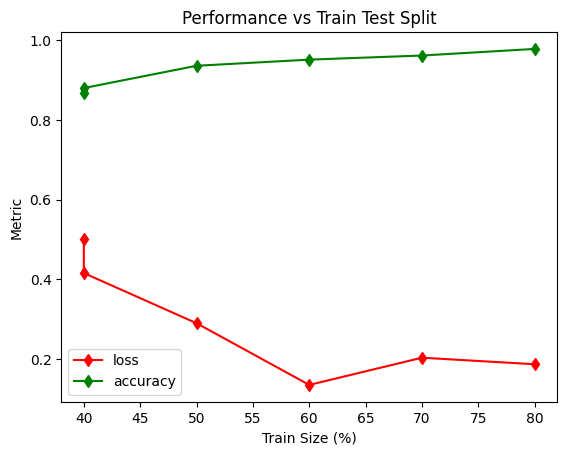

In [84]:
fig, axes = plt.subplots()

axes.plot(x_ticks_list, losses, color='red', marker = 'd', label='loss')
axes.plot(x_ticks_list, accuracies, color='green', marker='d', label = 'accuracy')
axes.set_xlabel('Train Size (%)')
axes.set_ylabel('Metric')
axes.set_title('Performance vs Train Test Split')
axes.legend()
plt.savefig('figures/CNN_train_test_split.png', bbox_inches='tight')
plt.show()

## Results vary using different filters

In [85]:

different_filter_names = ['butterworth', 'DWT', None]

train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3


hist_list = []
model_list = []
data_list = []
labels_list = []

for i in range(0, len(different_filter_names)):
    #obtaining split data within data gen as has to run anyway
    split_data = get_data_CNN(splits=train_splits, denoise_method = different_filter_names[i])

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20
    BATCH_SIZE = 16

    #should put epochs and stuff outside here
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 75.30it/s] 


denoising signals through butterworth filter method
normalising signals
splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - accuracy: 0.5321 - loss: 15.5275 - val_accuracy: 0.2196 - val_loss: 1.9823
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step - accuracy: 0.6319 - loss: 3.8385 - val_accuracy: 0.6499 - val_loss: 0.7394
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.7332 - loss: 5.2534 - val_accuracy: 0.3056 - val_loss: 1.2622
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.7084 - loss: 2.2316 - val_accuracy: 0.2196 - val_loss: 1.3111
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8567 - loss: 0.6420 - val_accuracy: 0.8190 - val_loss: 0.5048
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step - accuracy: 0.9459 - loss: 0.1460 - val_accuracy: 0.9050 - val_loss: 0.5800
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.9282 - loss: 0.2237 - val_accuracy: 0.9288 - val_loss: 0.5970
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.9627 - loss: 0.1254 - val_acc

100%|██████████| 221/221 [00:03<00:00, 69.90it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.5457 - loss: 17.6035 - val_accuracy: 0.4688 - val_loss: 0.6942
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.6578 - loss: 3.6356 - val_accuracy: 0.8694 - val_loss: 0.5732
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.8197 - loss: 2.5891 - val_accuracy: 0.7151 - val_loss: 0.6378
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.9651 - loss: 0.1126 - val_accuracy: 0.8783 - val_loss: 0.5363
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.9292 - loss: 0.3499 - val_accuracy: 0.3412 - val_loss: 1.7001
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.9412 - loss: 0.2883 - val_accuracy: 0.8516 - val_loss: 0.4395
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.9995 - loss: 0.0264 - val_accuracy: 0.9169 - val_loss: 0.3758
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 1.0000 - loss: 0.0183 - val_acc

100%|██████████| 221/221 [00:01<00:00, 178.29it/s]


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.5873 - loss: 19.1786 - val_accuracy: 0.7864 - val_loss: 0.7688
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.7361 - loss: 3.8866 - val_accuracy: 0.6617 - val_loss: 1.7415
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.8624 - loss: 4.4042 - val_accuracy: 0.7596 - val_loss: 0.7538
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.9258 - loss: 0.4956 - val_accuracy: 0.9169 - val_loss: 0.3123
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9355 - loss: 0.4567 - val_accuracy: 0.7478 - val_loss: 1.2268
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9687 - loss: 0.2223 - val_accuracy: 0.7953 - val_loss: 0.7092
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9410 - loss: 0.4846 - val_accuracy: 0.9080 - val_loss: 0.5643
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9813 - loss: 0.1357 - val_acc

In [86]:
losses = []
accuracies = []

for i in range(len(different_filter_names)):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']

    loss, accuracy = model_list[i].evaluate(X_test, y_test, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)